- https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf
- https://files.stlouisfed.org/files/htdocs/conferences/2014-nber-nsf/docs/papers/Nicholson,%20Will.pdf

- https://medium.com/slalom-technology/failing-fast-with-deepar-neural-networks-for-time-series-ef442bf03567

# Goals

- model should reduce to fb prophet when some input parameter is 1 (e.g. number of layers) and before any link functions are applied. In other words, fb prophet should be a special case
- support arbitrary loss functions
- support multi-parameter distribution modeling
- can we incorporate https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform

In [1]:
import pandas as pd

df = pd.read_csv('LD2011_2014.txt', sep=';', thousands=',', index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [2]:
df.shape

(140256, 370)

In [3]:
df.index.rename('ds', inplace=True)

In [4]:
df.columns = [int(c.split('_')[-1]) for c in df.columns]
df = df.melt(ignore_index=False, value_vars=df.columns, var_name='id', value_name='usage')
df.head()

,id,usage
ds,,
2011-01-01 00:15:00,1,0.0
2011-01-01 00:30:00,1,0.0
2011-01-01 00:45:00,1,0.0
2011-01-01 01:00:00,1,0.0
2011-01-01 01:15:00,1,0.0


In [5]:
df.shape

(51894720, 2)

In [6]:
df = df.groupby(['id', pd.Grouper(freq='H')]).usage.sum()

In [7]:
df = df.to_frame().reset_index()
df.head()

,id,ds,usage
0,1,2011-01-01 00:00:00,0.0
1,1,2011-01-01 01:00:00,0.0
2,1,2011-01-01 02:00:00,0.0
3,1,2011-01-01 03:00:00,0.0
4,1,2011-01-01 04:00:00,0.0


In [8]:
df.shape

(12974050, 3)

In [9]:
T0 = pd.Timestamp(0)
df['t'] = (df.ds - T0).dt.total_seconds() / (60 * 60 * 24)

In [10]:
beginnings = df[df.usage.gt(0)].reset_index().groupby('id').ds.min()
beginnings

id
1     2012-01-01
2     2012-01-01
3     2012-01-01
4     2012-01-01
5     2012-01-01
         ...    
366   2012-01-01
367   2012-01-01
368   2012-01-01
369   2012-01-01
370   2013-01-01
Name: ds, Length: 370, dtype: datetime64[ns]

In [11]:
df = df[df.ds > df.id.map(beginnings)]
df.shape

(10484118, 4)

In [12]:
C = 1e9
df['usage'] /= C

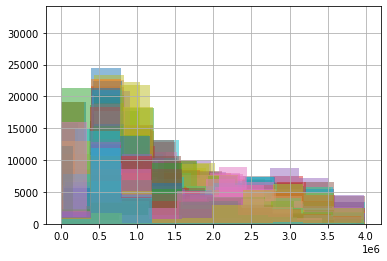

In [13]:
_ = df.groupby('id').usage.hist(alpha=.5)

In [14]:
%%time

df.sort_values(['id', 'ds'], inplace=True)
df['scaling_factor'] = (1 / C) + df.set_index('ds').groupby('id').usage.rolling('60D', closed='right', engine='numba', raw=True).mean().values
df.head()

CPU times: user 2.52 s, sys: 727 ms, total: 3.25 s
Wall time: 3.26 s


,id,ds,usage,t,scaling_factor
8761,1,2012-01-01 01:00:00,1.192893e+06,15340.041667,1.192893e+06
8762,1,2012-01-01 02:00:00,1.446701e+06,15340.083333,1.319797e+06
8763,1,2012-01-01 03:00:00,8.629442e+05,15340.125000,1.167513e+06
8764,1,2012-01-01 04:00:00,5.329949e+05,15340.166667,1.008883e+06
8765,1,2012-01-01 05:00:00,8.629442e+05,15340.208333,9.796954e+05


In [15]:
df.shape

(10484118, 5)

<AxesSubplot:xlabel='ds'>

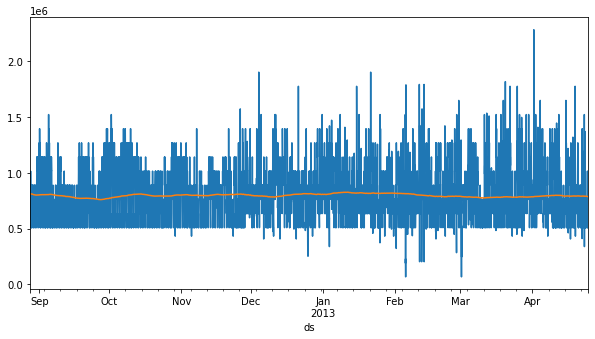

In [16]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))

df = pd.concat(
    d.iloc[60 * 24 * 4:]
    for _, d in df.groupby('id')
)
df.iloc[:60 * 24 * 4:].set_index('ds').usage.plot()
df.iloc[:60 * 24 * 4].set_index('ds').scaling_factor.plot()

In [17]:
df.head()

,id,ds,usage,t,scaling_factor
14521,1,2012-08-28 01:00:00,8.883249e+05,15580.041667,809168.781726
14522,1,2012-08-28 02:00:00,8.883249e+05,15580.083333,809256.909193
14523,1,2012-08-28 03:00:00,7.614213e+05,15580.125000,809256.909193
14524,1,2012-08-28 04:00:00,7.614213e+05,15580.166667,809345.036661
14525,1,2012-08-28 05:00:00,1.015228e+06,15580.208333,809609.419064


In [18]:
df_train = df[df.ds.lt('2014-07-01')]
df_test = df[df.ds.between('2014-07-01', '2014-07-30')]
df_train.shape, df_test.shape

((6764098, 5), (242628, 5))

In [19]:
id_map = {old: new for new, old in enumerate(df_train.id.unique())}
df_train['id'] = df_train.id.map(id_map)
df_test['id'] = df_test.id.map(id_map)
df_test = df_test[df_test.id.notnull()]

/Users/dantegates/virtualenvs/default1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dantegates/virtualenvs/default1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df_train.shape, df_test.shape

((6764098, 5), (242556, 5))

In [21]:
# import numpy as np
# import tensorflow as tf


# class SeasonalEmbedding(tf.keras.layers.Layer):
#     def __init__(self, *args, input_dim, period, N, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_dim = input_dim
#         self.period = period
#         self.N = N
#         # model params
#         self.a_n, self.b_n = [tf.keras.layers.Embedding(input_dim=input_dim, output_dim=N * 3, input_length=1)] * 2

#     def build(self, input_shape):
#         pass

#     def call(self, input_tensor, training=False):
#         id, t = input_tensor
#         n = (tf.range(self.N, dtype='float') + 1)[None, :, None]
#         N = self.N
#         instance_trend = self.fourier_series(
#             tf.reshape(
#                 tf.squeeze(self.a_n(id), axis=1),
#                 (-1, N, 3)),
#             tf.reshape(
#                 tf.squeeze(self.b_n(id), axis=1),
#                 (-1, N, 3)),
#             t[:, None],
#             n,
#             self.period)
#         global_trend = self.fourier_series(
#              tf.reshape(
#                 tf.squeeze(self.a_n(tf.zeros_like(id)), axis=1),
#                 (-1, N, 3)),
#              tf.reshape(
#                 tf.squeeze(self.b_n(tf.zeros_like(id)), axis=1),
#                 (-1, N, 3)),
#             t[:, None],
#             n,
#             self.period)
        
#         return tf.squeeze(instance_trend, axis=1) + tf.squeeze(global_trend, axis=1)

#     @staticmethod
#     def fourier_series(a_n, b_n, t, n, period):
#         x = (2 * np.pi * tf.multiply(t, n)) / period
#         return (
#             tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
#             + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
#         )


# class LinearTrendEmbedding(tf.keras.layers.Layer):
#     def __init__(self, *args, input_dim, max_t, n_changepoints=25, checkpoint_range=.8, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_dim = input_dim
#         self.max_t = max_t
#         self.n_changepoints = n_changepoints
#         self.checkpoint_range = checkpoint_range
#         self.δ = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=self.n_changepoints, input_length=1,
#                                            # l1 imitates Laplace prior from Prophet model
#                                            embeddings_regularizer='l1')
#         self.m = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)
#         self.k = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)

#     def build(self, input_shape):
#         self.s = tf.cast(tf.linspace(0, int(self.checkpoint_range * self.max_t), self.n_changepoints + 1), 'float')[1:]

#     def call(self, input_tensor, training=False):
#         id, t = input_tensor
        
#         instance_trend = self.trend(
#             tf.squeeze(self.δ(id), axis=1),
#             tf.squeeze(self.m(id), axis=1),
#             tf.squeeze(self.k(id), axis=1),
#             self.s,
#             t)
        
#         global_trend = self.trend(
#             tf.squeeze(self.δ(tf.zeros_like(id)), axis=1),
#             tf.squeeze(self.m(tf.zeros_like(id)), axis=1),
#             tf.squeeze(self.k(tf.zeros_like(id)), axis=1),
#             self.s,
#             t)

#         return instance_trend + global_trend

#     @staticmethod
#     def trend(δ, m, k, s, t):
#         A = tf.cast((t > s), 'float')

#         trend = tf.reduce_sum(tf.multiply(A, δ), axis=1, keepdims=True) * t + k

#         γ = tf.multiply(-s, δ)
#         offset = tf.reduce_sum(tf.multiply(A, γ), axis=1, keepdims=True) + m

#         return trend + offset

In [22]:
import numpy as np
import tensorflow as tf


class SeasonalEmbedding(tf.keras.layers.Layer):
    def __init__(self, *args, input_dim, period, N, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_dim = input_dim
        self.period = period
        self.N = N
        # model params
        self.a_n, self.b_n = [tf.keras.layers.Embedding(input_dim=input_dim, output_dim=N, input_length=1)] * 2


    def call(self, input_tensor, training=False):
        id, t = input_tensor
        n = (tf.range(self.N, dtype='float') + 1)[None, :]

        instance_trend = self.fourier_series(
            tf.squeeze(self.a_n(id), axis=1),
            tf.squeeze(self.b_n(id), axis=1),
            t,
            n,
            self.period)
        global_trend = self.fourier_series(
            tf.squeeze(self.a_n(tf.zeros_like(id)), axis=1),
            tf.squeeze(self.b_n(tf.zeros_like(id)), axis=1),
            t,
            n,
            self.period)
        
        return instance_trend + global_trend

    @staticmethod
    def fourier_series(a_n, b_n, t, n, period):
        x = (2 * np.pi * tf.multiply(t, n)) / period
        return (
            tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
            + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
        )
    
    
class SeasonalEmbeddingWithMovement(tf.keras.layers.Layer):
    def __init__(self, *args, period, N, **kwargs):
        super().__init__(*args, **kwargs)
        self.period = period
        self.N = N
        # model params
        self.a_n, self.b_n = [tf.keras.layers.Dense(self.N, activation='linear')] * 2

    def call(self, input_tensor, training=False):
        X, t = input_tensor
        n = (tf.range(self.N, dtype='float') + 1)[None, :]

        return self.fourier_series(
            self.a_n(X),
            self.b_n(X),
            n,
            self.period,
            t)

    @staticmethod
    def fourier_series(a_n, b_n, n, period, t):
        x = (2 * np.pi * tf.multiply(t, n)) / period
        return (
            tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
            + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
        )


class LinearTrendEmbedding(tf.keras.layers.Layer):
    def __init__(self, *args, input_dim, max_t, n_changepoints=25, checkpoint_range=.8, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_dim = input_dim
        self.max_t = max_t
        self.n_changepoints = n_changepoints
        self.checkpoint_range = checkpoint_range
        self.δ = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=self.n_changepoints, input_length=1,
                                           # l1 imitates Laplace prior from Prophet model
                                           embeddings_regularizer='l1')
        self.m = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)
        self.k = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)

    def build(self, input_shape):
        self.s = tf.cast(tf.linspace(0, int(self.checkpoint_range * self.max_t), self.n_changepoints + 1), 'float')[1:]

    def call(self, input_tensor, training=False):
        id, t = input_tensor
        
        instance_trend = self.trend(
            tf.squeeze(self.δ(id), axis=1),
            tf.squeeze(self.m(id), axis=1),
            tf.squeeze(self.k(id), axis=1),
            self.s,
            t)
        
        global_trend = self.trend(
            tf.squeeze(self.δ(tf.zeros_like(id)), axis=1),
            tf.squeeze(self.m(tf.zeros_like(id)), axis=1),
            tf.squeeze(self.k(tf.zeros_like(id)), axis=1),
            self.s,
            t)

        return instance_trend + global_trend

    @staticmethod
    def trend(δ, m, k, s, t):
        A = tf.cast((t > s), 'float')

        trend = tf.reduce_sum(tf.multiply(A, δ), axis=1, keepdims=True) * t + k

        γ = tf.multiply(-s, δ)
        offset = tf.reduce_sum(tf.multiply(A, γ), axis=1, keepdims=True) + m

        return trend + offset
    
    
class LinearTrendEmbeddingWithMovement(tf.keras.layers.Layer):
    def __init__(self, *args, t_range, n_changepoints=25, checkpoint_range=.8, **kwargs):
        super().__init__(*args, **kwargs)
        self.t_range = t_range
        self.n_changepoints = n_changepoints
        self.checkpoint_range = checkpoint_range
        self.δ = tf.keras.layers.Dense(self.n_changepoints, kernel_regularizer='l1')
        self.m = tf.keras.layers.Dense(1)
        self.k = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        self.s = tf.cast(tf.linspace(self.t_range[0], int(self.checkpoint_range * self.t_range[1]), self.n_changepoints + 1), 'float')[1:]
#         self.δ = self.add_weight(shape=(self.n_changepoints,), regularizer='l1')
#         self.m = self.add_weight(shape=(1,))
#         self.k = self.add_weight(shape=(1,))

    def call(self, input_tensor, training=False):
        X, t = input_tensor
        return self.trend(
            self.δ(X),
            self.m(X),
            self.k(X),
            self.s,
            t)

    @staticmethod
    def trend(δ, m, k, s, t):
        A = tf.cast((t > s), 'float')

        trend = (tf.reduce_sum(tf.multiply(A, δ), axis=1, keepdims=True) + k) * t

        γ = tf.multiply(-s, δ)
        offset = tf.reduce_sum(tf.multiply(A, γ), axis=1, keepdims=True) + m

        return trend + offset
    

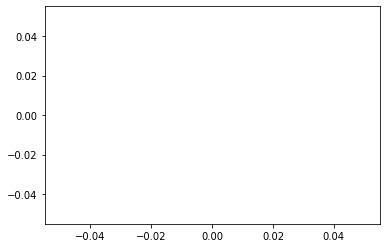

In [23]:
plt.plot(
    SeasonalEmbeddingWithMovement.fourier_series(
        np.random.normal(size=10),
        np.random.normal(size=10),
        np.arange(192, dtype='float32')[:, None] / 4,
        np.arange(10, dtype='float32'),
        24.
    ).numpy().ravel()
)

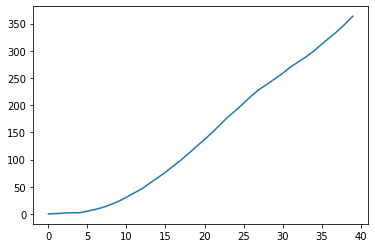

In [24]:
plt.plot(
    LinearTrendEmbeddingWithMovement.trend(
        np.random.normal(size=40),
        1.,
        1.,
        np.arange(40, dtype='float32'),
        np.arange(40, dtype='float32')[:, None] + 1.,
    ).numpy().ravel()
)

In [28]:
import numpy as np
import tensorflow as tf


pi = tf.constant(np.pi)
epsilon = tf.constant(1e-9)

ln = tf.math.log  # alias
lgamma = tf.math.lgamma  # alias


def nb_nll(z, model_outputs):
    mu, alpha = model_outputs[:, 0], model_outputs[:, 1]
    return -(
        lgamma(z + 1 / alpha) - lgamma(z + 1) - lgamma(1 / alpha)
        + (1 / alpha) * ln(1 / (1 + alpha * mu))
        + z * ln((alpha * mu) / (1 + alpha * mu))
    )


def scaler(inputs):
    mu, alpha, v = inputs[0], inputs[1], inputs[2]
    return tf.keras.layers.Concatenate()([mu * v, alpha / (2. * tf.sqrt(v))])
Scaler = tf.keras.layers.Lambda(scaler)

    
id_input = tf.keras.Input((1,), name='id')
t_input = tf.keras.Input((1,), name='t')
ν_input = tf.keras.Input((1,), name='scaling_factor')


def STL(df, embedding_dim=10, n_inner_layers=2, n_outer_layers=2, N=10, n_changepoints=20,
        periods=[1, 7, 365.25], T0=pd.Timestamp(0), output_activation='softplus'):
    
    T = (df.ds - T0).dt.total_seconds() / (3600 * 24)
    
    embeddings = tf.keras.layers.Reshape((embedding_dim,))(
        tf.keras.layers.Embedding(input_dim=df.id.nunique(), output_dim=embedding_dim, input_length=1)(id_input)
    )
    # TODO: mathematically this is unecessary. It could be that this layer helps push out
    # the embeddings, given the default weight initializer/constraints
    # If we were to stack layers, it would make more sense to do so within the seasonal embedding
    for _ in range(n_inner_layers):
        embeddings = tf.keras.layers.Dense(embedding_dim, activation='linear')(embeddings)
    
    seasonal_embeddings = [
        SeasonalEmbeddingWithMovement(period=period, N=N)([embeddings, t_input])
        for period in periods
    ]

    trend = tf.keras.layers.BatchNormalization()(
        LinearTrendEmbeddingWithMovement(input_dim=1, n_changepoints=n_changepoints, t_range=(T.min(), T.max()))([embeddings, t_input])
    )

    # perhaps a resnet layer would make sense here? If so maybe just use 4 instead
    # of `embedding_dim`
    X = tf.keras.layers.Concatenate()(seasonal_embeddings + [trend])
    for i in range(n_outer_layers - 1):
        X = tf.keras.layers.Dense(embedding_dim, activation=output_activation)(X)
    X = tf.keras.layers.Dense(1, activation=output_activation)(X)

    return X, seasonal_embeddings, trend


X_μ, seasonal_embeddings_μ, trend_μ = STL(df_train, embedding_dim=10, n_inner_layers=0, N=10,
                                          output_activation='softplus')
X_α, seasonal_embeddings_α, trend_α = STL(df_train, embedding_dim=10, n_inner_layers=0, N=10,
                                          output_activation='softplus')
# model_outputs = Scaler([X_μ, X_α, ν_input])
model_outputs = tf.keras.layers.Concatenate()([X_μ, X_α])

model = tf.keras.models.Model(
    inputs=[
        id_input,
        t_input,
        ν_input
    ],
    outputs=model_outputs)
model.compile(loss=nb_nll, optimizer='adam')


In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        3480        id[0][0]                         
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 10)        3480        id[0][0]                         
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 10)           0           embedding_2[0][0]                
____________________________________________________________________________________________

In [30]:
train_sample = df_train.sample(500_000, weights=df_train.usage)

model.fit(
    train_sample[['id', 't', 'scaling_factor']].to_dict('series'),
    train_sample.usage,
    batch_size=32,
    epochs=10,
    validation_data=(df_test[['id', 't', 'scaling_factor']].to_dict('series'), df_test.usage),
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(verbose=1, patience=3)]
)

Epoch 1/10
15625/15625 [==============================] - 24s 1ms/step - loss: 187116.1484 - val_loss: 77.4061
Epoch 2/10
15625/15625 [==============================] - 22s 1ms/step - loss: 56.2755 - val_loss: 20.6385
Epoch 3/10
15625/15625 [==============================] - 22s 1ms/step - loss: 21.1009 - val_loss: 18.4475
Epoch 4/10
15625/15625 [==============================] - 22s 1ms/step - loss: 19.6602 - val_loss: 17.7202
Epoch 5/10
15625/15625 [==============================] - 22s 1ms/step - loss: 18.7910 - val_loss: 17.2415
Epoch 6/10
15625/15625 [==============================] - 23s 1ms/step - loss: 17.9560 - val_loss: 16.5242
Epoch 7/10
15625/15625 [==============================] - 23s 1ms/step - loss: 17.4501 - val_loss: 15.8450
Epoch 8/10
15625/15625 [==============================] - 23s 1ms/step - loss: 16.6266 - val_loss: 15.3883
Epoch 9/10
15625/15625 [==============================] - 23s 1ms/step - loss: 15.9123 - val_loss: 15.2579
Epoch 10/10
15625/15625 [========

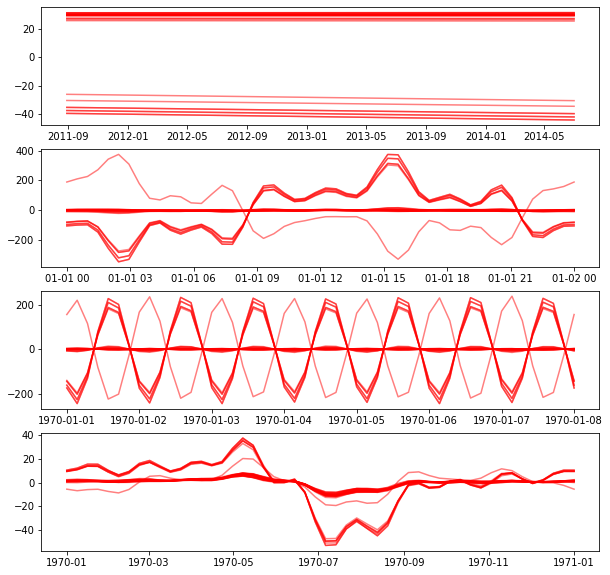

In [31]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

sampled_ids = np.random.choice(df_train.id.unique(), size=30)

trend_model = tf.keras.models.Model(inputs=[
        id_input,
        t_input,
    ], outputs=trend_μ)

for i in sampled_ids:
    T = np.linspace(df_train.t.min(), df_train.t.max())
    axs[0].plot(T0 + pd.to_timedelta(T, unit='days'),
                trend_model.predict({'t': T, 'id': np.zeros_like(T) + i}), color='r', alpha=.5)

for ax, E, P in zip(axs[1:], seasonal_embeddings_μ, [1, 7, 365.25]):
    T = np.linspace(0, P)
    seasonality_model = tf.keras.models.Model(inputs=[
        id_input,
        t_input,
    ], outputs=E)

    for i in sampled_ids:
        seasonal_embedding = seasonality_model.predict({'t': T, 'id': np.zeros_like(T) + i})
        ax.plot(T0 + pd.to_timedelta(T, unit='days'),
                seasonal_embedding, color='r', alpha=.5)


<AxesSubplot:>

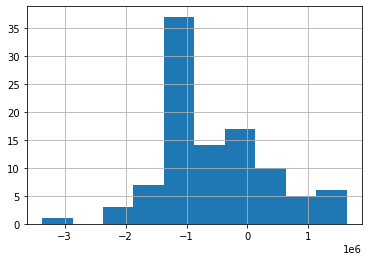

In [32]:
zz = df_train.sample(100)
y_test_params = model.predict(zz[['id', 't', 'scaling_factor']].to_dict('series'))
mu = y_test_params[:, 0]

(zz.usage - mu).hist()


<AxesSubplot:label='ba4ae248-25eb-4deb-8c00-5f716caf2f78', xlabel='ds'>

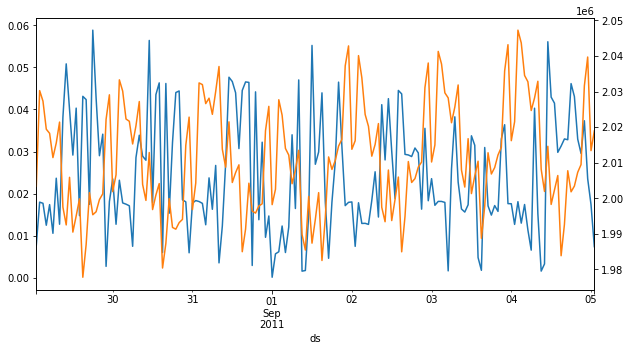

In [50]:
fig, ax = plt.subplots(figsize=(10, 5), sharey=True)

i = np.random.choice(df_train.id)
zz = df_train[df_train.id == i].set_index('ds').sort_index()
zz = zz.loc[:zz.index.min() + pd.to_timedelta('7D')]
zz['p'] = model.predict(zz[['id', 't', 'scaling_factor']].to_dict('series'))[:, 0]
zz.usage.plot(ax=ax, color='C0')
zz.p.plot(ax=ax.twinx(), color='C1')


<AxesSubplot:label='9e60e031-0d2f-44dc-9154-967d901fa84f', xlabel='ds'>

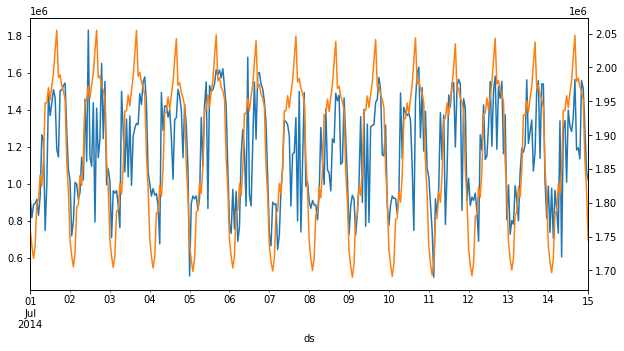

In [35]:
fig, ax = plt.subplots(figsize=(10, 5), sharey=True)

i = np.random.choice(df_test.id)
zz = df_test[df_test.id == i].set_index('ds').sort_index()
zz = zz.loc[:zz.index.min() + pd.to_timedelta('14D')]
zz['p'] = model.predict(zz[['id', 't', 'scaling_factor']].to_dict('series'))[:, 0]
zz.usage.plot(ax=ax, color='C0')
zz.p.plot(ax=ax.twinx(), color='C1')


<ErrorbarContainer object of 3 artists>

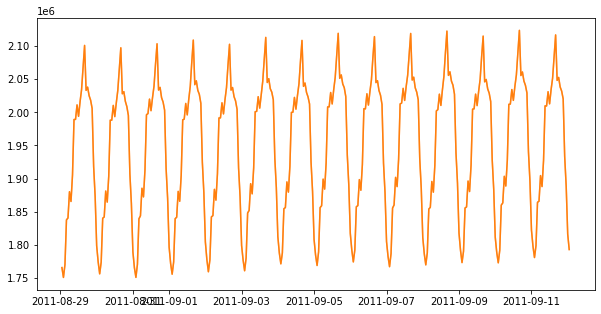

In [36]:
import scipy.stats as ss


fig, ax = plt.subplots(figsize=(10, 5))

zz = df_train[df_train.id == i].set_index('ds').sort_index()
zz = zz.loc[:zz.index.min() + pd.to_timedelta('14D')]
m, a = model.predict(zz[['id', 't', 'scaling_factor']].to_dict('series')).T
var = m * (1 + (m / a))
# zz.usage.plot(ax=ax, color='C0')

rv = ss.binom(
    n=(m ** 2) / (var - m),
    p=m / var
)
ax.plot(zz.index, m, color='C1')
lower, upper = rv.interval(.9)
ax.errorbar(
    x=zz.index,
    y=m,
    yerr=(lower, upper),
    color='C1',
    alpha=.5
)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

i = np.random.choice(df_train.id)
zz = df_train[df_train.id == i].set_index('ds').sort_index()
zz = zz.loc[:zz.index.min() + pd.to_timedelta('7D')]
zz['p'] = model.predict(zz[['id', 't', 'scaling_factor']].to_dict('series'))[:, 0]
zz.usage.plot(ax=ax, alpha=.2)
zz.p.plot(ax=ax)

In [ ]:
print(i)

fig, axs = plt.subplots(4, 1, figsize=(10, 10))


sampled_ids = [np.random.choice(1, size=30)]


trend_model = tf.keras.models.Model(inputs=inputs, outputs=linear_trend_μ)

for i in sampled_ids:
    T = np.linspace(df_train.t.min(), df_train.t.max())
    axs[0].plot(T0 + pd.to_timedelta(T, unit='days'),
                trend_model.predict({'t': T, 'id': np.zeros_like(T) + i}), color='r', alpha=.5)

for ax, E, P in zip(axs[1:], seasonal_embeddings_μ, [1, 7, 365.25]):
    T = np.linspace(0, P)
    seasonality_model = tf.keras.models.Model(inputs=inputs, outputs=E)

    for i in sampled_ids:
        seasonal_embedding = seasonality_model.predict({'t': T, 'id': np.zeros_like(T) + i})
        ax.plot(T0 + pd.to_timedelta(T, unit='days'),
                seasonal_embedding, color='r', alpha=.5)
